# PyTorch experiment tracking

In [1]:
import torch
from torch import nn
import torchvision
from torchinfo import summary
from torchvision import transforms

torch.__version__, torchvision.__version__

('2.2.0+cu121', '0.17.0+cu121')

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source: str,
                 destination: str,
                 remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination."""
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, create it
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)
        # Unzip target file
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file if needed
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [46]:
source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

image_path = download_data(source=source, destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory already exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

# 2. Create Datasets and DataLoaders

In [5]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [6]:
# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# Create transform pipeline manually

from torchvision import transforms

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
# Create DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x22339f1d730>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Create DataLoaders using automcatically created transforms

In [8]:
# Setup dirs
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Setup pretrained weights (plenty of these weights available in torvision models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=automatic_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x22339f1dfd0>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model, freeze the bnase layers and change the classifier head

In [9]:
# Note: This is how a pretrained mdoel would be created prior to torchvision v0.13
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Downlaod the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
# Freeze all the layers by setting their requires_grad attribute to False
for param in model.features.parameters():
    param.requires_gard = False

In [11]:
# Adjust the classifier head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

In [12]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
from torchinfo import summary

summary(model,
       input_size=(32, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# 4. Train a single model and track results

In [14]:
# Define loss function optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [16]:
from tqdm import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
              }
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        # Update results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ## New: Experiment tracking
        writer.add_scalars(main_tag="Loss",
                          tag_scalar_dict={"train_loss": train_loss,
                                          "test_loss": test_loss},
                          global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                          tag_scalar_dict={"train_acc": train_acc,
                                          "test_acc": test_acc},
                          global_step=epoch)
        writer.add_graph(model=model,
                        input_to_model=torch.randn(32, 3, 224, 224).to(device))
    # Close the writer
    writer.close()
    print("[INFO] Training Finished")

    return results

In [17]:
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=50,
                device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:48<00:00, 10.57s/it]

[INFO] Training Finished


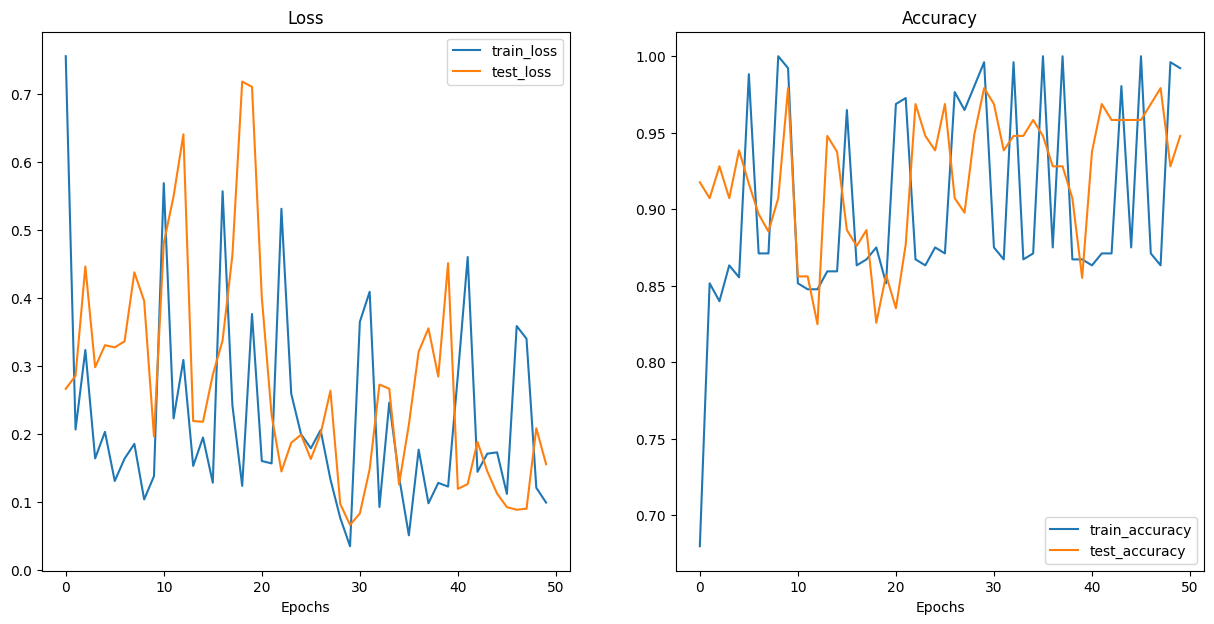

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 5. View our model's results with TensorBoard

In [36]:
# Viewing our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7896), started 0:09:34 ago. (Use '!kill 7896' to kill it.)

In [28]:
results["train_acc"][-1], results["test_acc"][-1]

(0.9921875, 0.9479166666666666)

## 6. Create a function to prepare a `SummaryWriter()` instance

In essence. one experiment = one folder.

For example, we'd like to track:
* Experiment data/timestamp
* Experiment name
* Model name
* Extra - is there anyting else that should be tracked?

So ideally, we end up tracking experiments to a directory:
runs/YYY-MM-DD/experiment_name/model_names/extra

In [33]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name:str,
                 extra: str = None):
    """Create a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory"""
    from datetime import datetime
    import os

    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [34]:
exmple_writer = create_writer(experiment_name="data_10_percent",
                             model_name="efficientb0",
                             extra="50_epochs")

[INFO] Created SummaryWriter saving to runs\2024-09-12\data_10_percent\efficientb0\50_epochs


## Updates train loop with SummaryWriter()

In [37]:
from tqdm import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter()) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
              }
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        # Update results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ## New: Experiment tracking

        if writer:
            writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                              global_step=epoch)
            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))
            # Close the writer
            writer.close()
        else:
            pass
    print("[INFO] Training Finished")

    return results

## 7. Setting up a series of modelling experiments

* Setup 2x modelling experiments with effnetb0, pizza, steakm sushi data and train one model for 5 epochs and another model for 10 epochs

### 7.1 What experiments are we going to run?

1. Model size
2. Dataset size
3. Training time

In [50]:
# Download 20 percent dataset

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [53]:
data_20_percent_path

WindowsPath('data/pizza_steak_sushi_20_percent')

In [59]:
# Setup train and test dir paths for datasets of 10% and 20%

# Setup train and test dir paths for datasets 20%
train_dir_10 = image_path / "train"
test_dir_10 = image_path / "test"

train_dir_20 = data_20_percent_path / "train"
test_dir_20 = data_20_percent_path / "test"

In [86]:
# Setting up dataloaders

train_dataloader_10, test_dataloader, class_names_10 = data_setup.create_dataloaders(train_dir=train_dir_10,
                                                                                       test_dir=test_dir_10,
                                                                                        transform=automatic_transforms,
                                                                                       batch_size=32)

train_dataloader_20, test_dataloader, class_names_20 = data_setup.create_dataloaders(train_dir=train_dir_20,
                                                                                       test_dir=test_dir_20,
                                                                                        transform=automatic_transforms,
                                                                                       batch_size=32)

In [87]:
len(train_dataloader_10), len(test_dataloader), class_names_10

(8, 5, ['pizza', 'steak', 'sushi'])

In [88]:
len(train_dataloader_20), len(test_dataloader), class_names_20

(15, 5, ['pizza', 'steak', 'sushi'])

## 7.5 Create feature extractor models

Creating two functions
1. Creates a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head.
2. Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head.


In [71]:
import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\Jamshid/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|█████████████████████████████████████████████████████████████████████████████| 35.2M/35.2M [00:02<00:00, 14.0MB/s]


In [75]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffnetB0 feature extractor
def create_effnetb0():
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    # change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model...")
    return model


# Create an EffnetB2 feature extractor
def create_effnetb2():
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    # change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [76]:
from torchinfo import summary

summary(model=create_effnetb0(),
       input_size=(32, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

[INFO] Created new effnetb0 model...


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [77]:
from torchinfo import summary

summary(model=create_effnetb2(),
       input_size=(32, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

[INFO] Created new effnetb2 model...


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 7.6 Create experiments and setup training code

In [84]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10,
                    "data_20_percent": train_dataloader_20
                    }

In [92]:
%%time
from going_modular.utils import save_model

experiment_number = 0
# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through in num epochs:
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:
            # Print out info
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train target model with target dataloader and track experiments
            results = train(model=model,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                           optimizer=optimizer,
                           epochs=epochs,
                           device=device,
                           writer=create_writer(experiment_name=dataloader_name,
                                               model_name=model_name,
                                               extra=f"{epochs}_epochs"))
            save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                      target_dir="model",
                      model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_10_percent\effnetb0\5_epochs


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.53s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_10_percent\effnetb2\5_epochs


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.63s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_10_percent\effnetb0\10_epochs


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_10_percent\effnetb2\10_epochs


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.52s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_20_percent\effnetb0\5_epochs


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.94s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_20_percent\effnetb2\5_epochs


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.10s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_20_percent\effnetb0\10_epochs


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:38<00:00,  9.86s/it]


[INFO] Training Finished
[INFO] Saved model to: model\effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-09-12\data_20_percent\effnetb2\10_epochs


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.26s/it]

[INFO] Training Finished
[INFO] Saved model to: model\effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 1min 13s
Wall time: 10min 19s


## 8. View experiments in TensorBoard
Now, Let's Visualize, Visualize, Visualize

In [93]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7896), started 3:27:37 ago. (Use '!kill 7896' to kill it.)

# 9. Load the best model and make predictions with it
This is our best model file path: "model/effnetb2_data_20_percent_5_epochs.pth"


In [95]:
best_model_path = "model/effnetb2_data_20_percent_5_epochs.pth"

# Instantiate a new instance of EffNetB2 (to laod in the saved state_dict())
best_model = create_effnetb2()

# Load the saved model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [97]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [98]:
data_20_percent_path

WindowsPath('data/pizza_steak_sushi_20_percent')

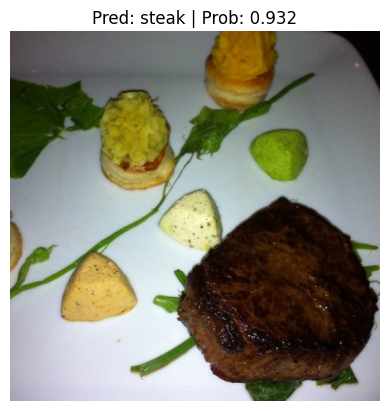

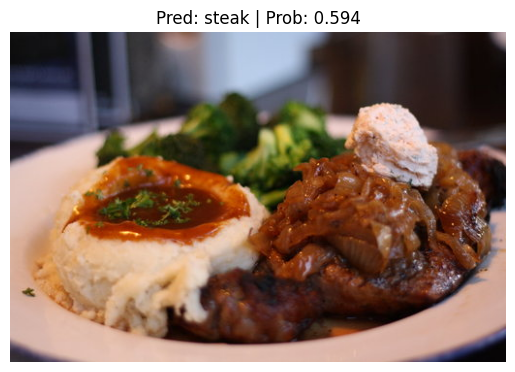

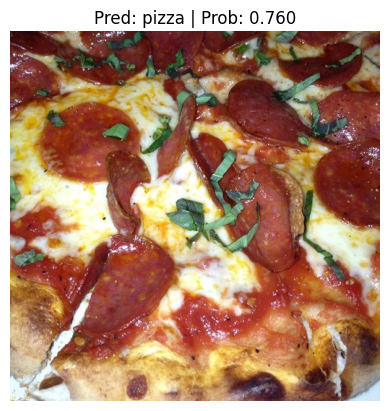

In [104]:
# Import function to make predictions on images and plot them

from going_modular.predictions import pred_and_plot_image

# get a random list of 3 image path names from the test dataset
import random

num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                      k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224, 224))

## 9.1 Predict on a custom image

In [108]:
# Download the image
import requests

# Setup custom image path
custom_image_path = "data/pizza_grandpa_img.jpg"

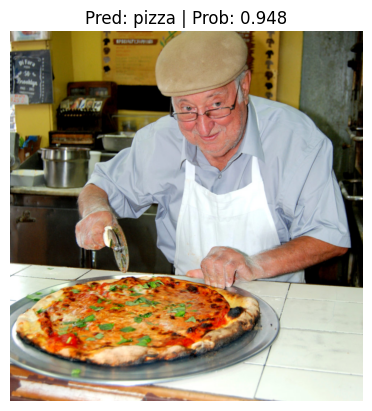

In [111]:
pred_and_plot_image(model=model,
                   image_path=custom_image_path,
                   class_names=class_names)